In [36]:
import json
from enum import Enum
import numpy as np
import networkx as nx
import random

In [214]:
class TYPES_OF_GRAPH(Enum):
    DI = 1
    MULTI = 2

class Node:
    def __init__(self, id, is_start, label, response) -> None:
        self.id = id
        self.is_start = is_start
        self.response = response
        self.label = label

    def __eq__(self, other):
        if isinstance(other, Node):
            return self.response == other.response
        return False

    def __hash__(self):
        return hash(self.response)

    def __str__(self) -> str:
        return f"{self.id}: {self.response}"
    

class Link:
    def __init__(self, source: Node, target: Node) -> None:
        self.source = source
        self.target = target
        self.requests = []

    def add_response(self, response: str):
        if response not in self.requests:
            self.requests.append(response)

    def __str__(self) -> str:
        repr = "{self.source}->{self.target}:"
        for x in self.requests:
            repr+=x
        return repr

    def __repr__(self) -> str:
        repr = f"{self.source}->{self.target}:"
        for x in self.requests:
            repr+=x
        return repr
    
    def __eq__(self, other):
        if isinstance(other, Link):
            return self.source == other.source and self.target == other.target 
        return False

In [192]:
with open('./identical_except_numbering/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./identical_except_numbering/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [224]:
class Graph:
    def __init__(self, graph: dict, type: TYPES_OF_GRAPH) -> None:
        if type == TYPES_OF_GRAPH.MULTI:
            self.nx_graph = nx.MultiDiGraph()
        else:
            self.nx_graph = nx.DiGraph()
        node_count = len(graph['nodes'])
        self.type = type
        self.nodes = []
        self.transitions = [[None for _ in range(node_count + 1)] for _ in range(node_count + 1)]
        self.graph_degrees = []
        for node in graph['nodes']:
            self.nodes.append(Node(node['id'], node['is_start'], node['label'], node['response']))
            self.nx_graph.add_node(node['id'], request=node['response'])
        for link in graph['links']:
            first = link['source']
            second = link['target']
            link_obj = Link(first, second)
            link_obj.add_response(link['request'])
            self.transitions[first][second] = link_obj
            self.nx_graph.add_edges_from([(first, second, {"requests": link['request']})])
        for i in range(1, node_count + 1):
            self.graph_degrees.append(sum(1 for x in self.transitions[i] if x is not None))


In [225]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.DI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.DI)

## Вспомогательные функции

In [265]:
def check_if_nodes_identical(graph_1: Graph, graph_2: Graph):
       #check if we have the same amount of nodes:
    if len(graph_1.nodes) != len(graph_2.nodes):
        return False
    
    #check if the nodes are in the same 
    unmatched_1 = set(graph_1.nodes)
    unmatched_2 = set(graph_2.nodes)
    return unmatched_1 == unmatched_2


In [268]:
def check_if_links_identical(graph_1: Graph, graph_2: Graph):
    unmatched_first = []
    unmatched_second = []
    node_cnt = len(graph_1.nodes)
    for i in range(node_cnt):
        for j in range(node_cnt):
            if graph_1.transitions[i][j] is not None and graph_2.transitions[i][j] is not None:
                if graph_1.transitions[i][j].requests == graph_2.transitions[i][j].requests:
                    continue
                else:
                    if set(graph_1.transitions[i][j].requests) == set(graph_2.transitions[i][j].requests):
                        continue
                    else:
                        # print(graph_1.transitions[i][j].requests)
                        # print(graph_2.transitions[i][j].requests)
                        # raise ValueError("The target and source are identical, but the responses aren't")
                        unmatched_first.append((i,j,graph_1.transitions[i][j].requests))
                        unmatched_second.append((i,j,graph_2.transitions[i][j].requests))
            elif graph_1.transitions[i][j] is not None:
                unmatched_first.append((i,j,graph_1.transitions[i][j].requests))
            elif graph_2.transitions[i][j] is not None:
                unmatched_second.append((i,j,graph_2.transitions[i][j].requests))
            else:
                continue
    return unmatched_first, unmatched_second


In [269]:
def check_graph_isomorphism(graph1, graph2):
    flg = check_if_nodes_identical(graph1, graph2)
    if flg is False:
        return False
    a,b = check_if_links_identical(graph1, graph2)
    for e in a:
        print(e)
    print("_______")
    for e in b:
        print(e)
    print("_______")

## Проверяем на изоморфизм

In [226]:
ground_truth_graph.nx_graph.edges

OutEdgeView([(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (4, 2), (5, 6), (6, 7)])

In [227]:
do_mapping(ground_truth_graph.nx_graph, generated_graph.nx_graph)

Graphs are isomorphic and correct


{4: 4, 2: 3, 3: 2, 5: 5, 1: 1, 6: 6, 7: 7}

### Проверим на изоморфичность в случае, когда на ребрах несколько реплик, но графы одинаковы

In [228]:
with open('./identical_with_several_requests/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./identical_with_several_requests/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [229]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.DI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.DI)

In [232]:
do_mapping(ground_truth_graph.nx_graph, generated_graph.nx_graph)

Graphs are isomorphic and correct


{4: 4, 2: 3, 3: 2, 5: 5, 1: 1, 6: 6, 7: 7}

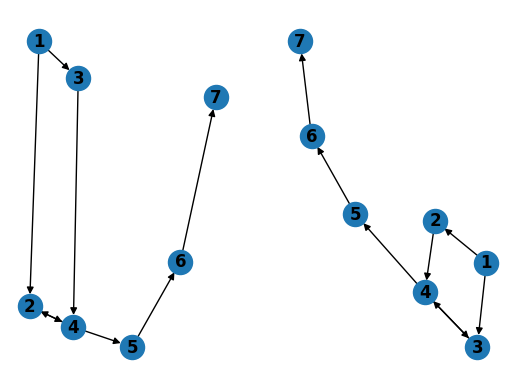

In [53]:

subax1 = plt.subplot(121)
nx.draw(ground_truth_graph.nx_graph, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(generated_graph.nx_graph, with_labels=True, font_weight='bold')

### Проверка когда есть несоотвествие

In [233]:
with open('./nonidentical_graphs/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./nonidentical_graphs/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [235]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.MULTI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.MULTI)

In [236]:
ground_truth_graph.nx_graph.edges

OutMultiEdgeView([(1, 3, 0), (1, 3, 1), (1, 2, 0)])

In [238]:
def find_split_nodes(g1, g2):
    # Create dictionaries to map edges based on 'requests' attribute
    g1_requests = {}
    g2_requests = {}

    g1_edges = {}
    g2_edges = {}

    for u, v, data in g1.edges(data=True):
        request = data.get('requests')
        if request not in g1_requests:
            g1_requests[request] = []
        g1_requests[request].append((u, v))

    for u, v, data in g2.edges(data=True):
        request = data.get('requests')
        if request not in g2_requests:
            g2_requests[request] = []
        g2_requests[request].append((u, v))

    for u, v, data in g1.edges(data=True):
        key=f'{u}->{v}'
        if key not in g1_edges:
            g1_edges[key] = []
        g1_edges[key].append(*data.values())

    for u, v, data in g2.edges(data=True):
        key=f'{u}->{v}'
        if key not in g2_edges:
            g2_edges[key] = []
        g2_edges[key].append(*data.values())
    
    # print(g1_edges)
    # print(g2_edges)

    # print(g1_requests)
    # print(g2_requests)

    g1_split = {}
    g2_split = {}
    for edge, data in g1_edges.items():
        if len(data) > 1 and len(g2_edges[edge]) < len(data):
                g1_node = int(edge.split('->')[1])
                g2_end_nodes = []
                for request in data:
                    end_node = g2_requests[request][0][1]
                    g2_end_nodes.append(end_node)
                print(f"in g1 Node {g1_node} is split into {g2_end_nodes} in g2")
                g1_split[g1_node] = g2_end_nodes
    for edge, data in g2_edges.items():
        if len(data) > 1 and len(g1_edges[edge]) < len(data):
                g2_node = int(edge.split('->')[1])
                g1_end_nodes = []
                for request in data:
                    end_node = g1_requests[request][0][1]
                    g1_end_nodes.append(end_node)
                print(f"in g2 Node {g2_node} is split into {g1_end_nodes} in g1")
                g2_split[g2_node] = g1_end_nodes
                
    return g1_split,g2_split 
find_split_nodes(ground_truth_graph.nx_graph, generated_graph.nx_graph)

in g1 Node 3 is split into [3, 2] in g2


({3: [3, 2]}, {})

In [239]:
G1 = ground_truth_graph.nx_graph
G2 = generated_graph.nx_graph

In [242]:
def do_mapping(g1, g2):
    GM = nx.isomorphism.DiGraphMatcher(g1, g2, edge_match=lambda x, y: set(x['requests']).intersection(set( y['requests'])) is not None)
    are_isomorphic = GM.is_isomorphic()
    if are_isomorphic:
        print("Graphs are isomorphic and correct")
        mapping = nx.vf2pp_isomorphism(g1, g2, node_label=None)
        return mapping
    mapping = {}
    for i in range(1, len(g1.nodes)):
        mapping[i] = i
    g1_unmatched_nodes, g2_unmatched_nodes = find_split_nodes(g1, g2)
    print(g1_unmatched_nodes)
    print(g2_unmatched_nodes)
    for k, v in g1_unmatched_nodes.items():
        elem = random.choice(v)
        mapping[k] = elem
        for node in v:
            if node != elem:
                mapping[node] = None
    print(mapping)

In [243]:
do_mapping(G1, G2)

in g1 Node 3 is split into [3, 2] in g2
{3: [3, 2]}
{}
{1: 1, 2: None, 3: 3}
